In [2]:
import gc  #垃圾回收，解决循环引用问题  https://blog.csdn.net/hzw13816194861/article/details/77867119
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb   #导入xgboost
from xgboost import plot_importance
import matplotlib.pyplot as plt

关于XGBoost的优点：  （常用函数和参数介绍见https://blog.csdn.net/luanpeng825485697/article/details/79907149 ）
1. 在代价函数里加入正则项，用于控制模型的复杂度。（代价函数？）从Bias-variance tradeoff角度来讲，
   正则项降低了模型的variance，使学习出来的模型更加简单，防止过拟合，优于传统的GBDT。  
     
     
2. XGBoost工具支持并行。XGBoost在训练之前，预先对数据进行了排序，然后保存为block结构，
   后面的迭代中重复地使用这个结构，大大减小计算量。（决策树学习需要在对特征的值的排序上花费大量时间）  
     
     
3. 对于特征的值有缺失的样本，xgboost可以自动学习出它的分裂方向。  
  
  
4. 先从顶到底建立所有可以建立的子树，再从底到顶反向进行剪枝。比起GBM，这样不容易陷入局部最优解。（局部最优解）  
  
  
5. XGBoost可以加载多种数据格式的训练数据。包括libsvm格式的文本数据、numpy的二维数组、XGBoost的二进制缓存文件（加载的数据存储在对象DMatrix中）。　　


In [3]:
#导入数据，并设定特征列数据格式
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed'] 

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        }

start_time = time.time()

train = pd.read_csv("train.csv",  nrows=6100,  parse_dates=['click_time'], usecols=train_columns, dtype=dtypes)

print('[{}] Finished to load data'.format(time.time() - start_time))

[0.054207801818847656] Finished to load data


将click_time中的day以一周中的某一天和一年中的某一天表示（便于分析），并将时间day-hour-minute-second拆分为单独的特征列

In [4]:
def time_feature(df):
    df['dow']=df['click_time'].dt.dayofweek.astype('uint8')
    df['doy']=df['click_time'].dt.dayofyear.astype('uint8')
    
    df['hour'] = df['click_time'].dt.hour.astype('uint8')
    df['minute'] = df['click_time'].dt.minute.astype('uint8')
    df['second'] = df['click_time'].dt.second.astype('uint8')
    
    return df

train = time_feature(train)

In [5]:
train.drop(['click_time'], axis=1, inplace=True)  #删除click_time列

考虑 特定feature 或 某种组合 可能对有效点击的贡献更大（见《feature engineering & importance  testing》：https://www.kaggle.com/nanomathias/feature-engineering-importance-testing）

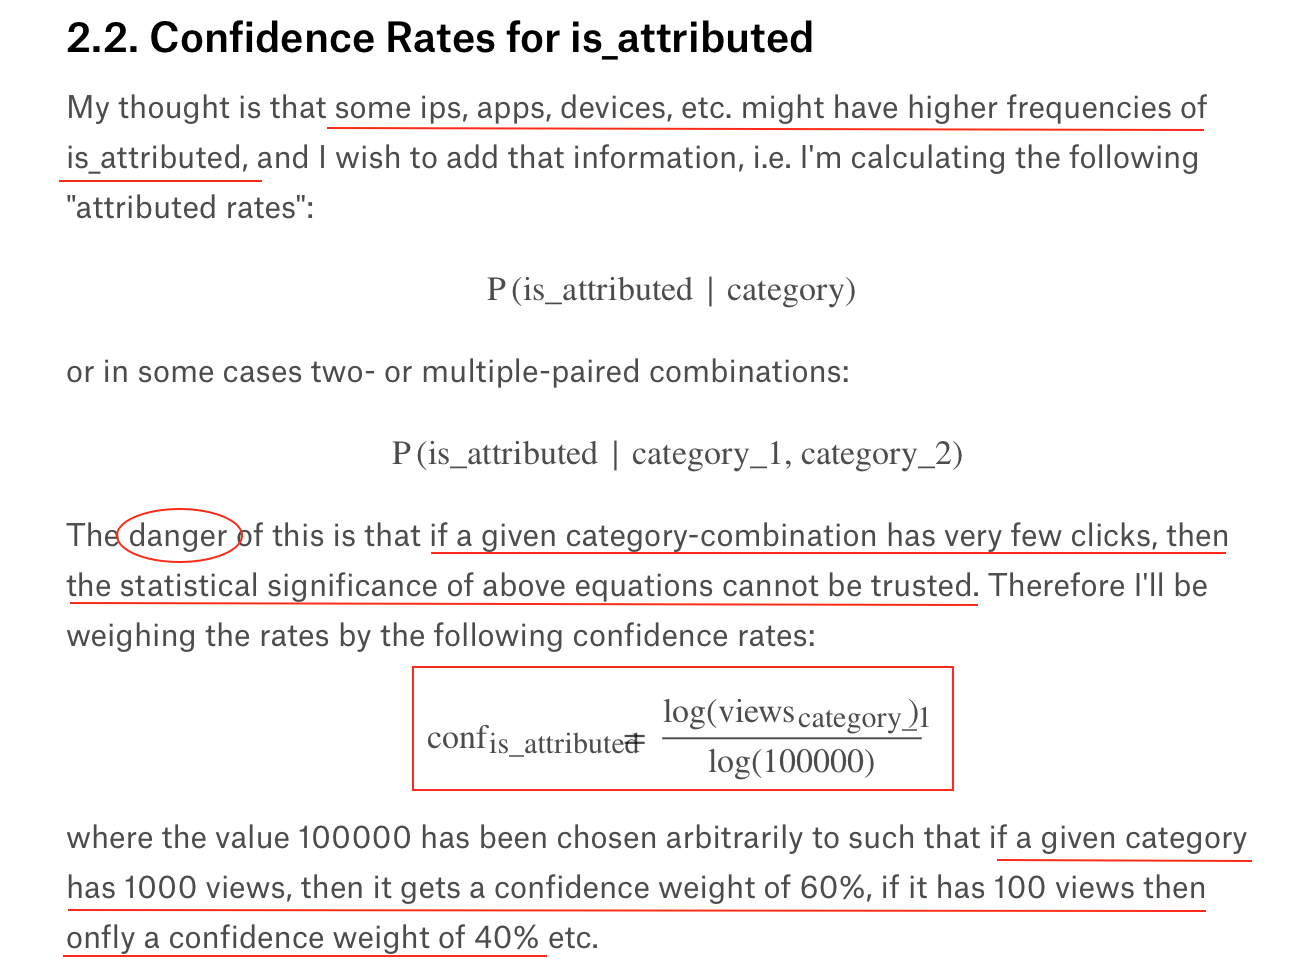

In [6]:
from IPython.display import Image
Image(filename='confRate.png')

建立特征组合

In [7]:
attribution_categories = [        
    # V1 Features #
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # V2 Features #
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]

问题：
1. 没有考虑点击时间和下载时间的间隔问题
2. 分组未完全覆盖所有可能的组合，存在一定的主观性-->  一一测试？
3. 在线学习？
***

学习：
1. groupby函数分组：https://blog.csdn.net/qq_32618817/article/details/80587228  
2. sum和count的区别：sum只统计非0行，count统计不区分0/1
3. apply间接调用函数：https://www.cnblogs.com/paranoia/p/6196865.html  
4. merge函数：https://blog.csdn.net/starter_____/article/details/79198137 
5. reset_index 重新排序，使分组更整齐：https://blog.csdn.net/qq_24753293/article/details/80918414 
6. rename()函数更改标签名https://www.cnblogs.com/ming-zi/p/6647589.html 
***
为每一个特征组合的confidence rate建立单独的列，添加到原数据中

In [8]:
for cols in attribution_categories :
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    train = train.merge(
        group_object['is_attributed']. apply(rate_calculation).reset_index(). \
        rename( index=str,columns={'is_attributed': new_feature})[cols + [new_feature]],\
        on=cols, how='left'
    )

train.head()

>> Calculating confidence-weighted rate for: ['ip'].
   Saving to: ip_confRate. Group Max /Mean / Median / Min: 40 / 2.06 / 1.0 / 1
>> Calculating confidence-weighted rate for: ['app'].
   Saving to: app_confRate. Group Max /Mean / Median / Min: 1078 / 108.93 / 7.5 / 1
>> Calculating confidence-weighted rate for: ['device'].
   Saving to: device_confRate. Group Max /Mean / Median / Min: 5799 / 554.55 / 2.0 / 1
>> Calculating confidence-weighted rate for: ['os'].
   Saving to: os_confRate. Group Max /Mean / Median / Min: 1490 / 88.41 / 12.0 / 1
>> Calculating confidence-weighted rate for: ['channel'].
   Saving to: channel_confRate. Group Max /Mean / Median / Min: 534 / 55.45 / 21.5 / 1
>> Calculating confidence-weighted rate for: ['app', 'channel'].
   Saving to: app_channel_confRate. Group Max /Mean / Median / Min: 416 / 30.65 / 12.0 / 1
>> Calculating confidence-weighted rate for: ['app', 'os'].
   Saving to: app_os_confRate. Group Max /Mean / Median / Min: 305 / 8.71 / 2.0 / 1
>> Ca

,ip,app,device,os,channel,is_attributed,dow,doy,hour,minute,...,app_confRate,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate
0,83230,3,1,13,379,0,0,54,14,32,...,0.0,0.001038,0.00178,0.0,0.0,0.0,0.0,0.0,0.0,0.001828
1,17357,3,1,19,379,0,0,54,14,33,...,0.0,0.001038,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,35810,3,1,13,379,0,0,54,14,34,...,0.0,0.001038,0.00178,0.0,0.0,0.0,0.0,0.0,0.0,0.001828
3,45745,14,1,13,478,0,0,54,14,34,...,0.0,0.001038,0.00178,0.0,0.0,0.0,0.0,0.0,0.0,0.001828
4,161007,3,1,13,379,0,0,54,14,35,...,0.0,0.001038,0.00178,0.0,0.0,0.0,0.0,0.0,0.0,0.001828


设置参数（以下参数来自Pranav的kernel, pranav也做过关于不平衡数据的处理，见 https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-lb-0-9680/comments )  
  
参数调优完全指南：https://www.cnblogs.com/mfryf/p/6293814.html

In [9]:
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

In [10]:
is_valid=True    #可通过修改is_valid的值来改变逻辑语句中的模型训练方法
y=train['is_attributed']  
train.drop(['is_attributed'], axis=1, inplace=True)

调用xgboost 划分训练&测试集，生成模型

In [11]:
if (is_valid == True):
    x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)  #test_size指定取10%作为测试集
    dtrain = xgb.DMatrix(x1, y1)    
    dvalid = xgb.DMatrix(x2, y2)  #形成xgboost的标准训练集和测试集
    del x1, y1, x2, y2 
    gc.collect()
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]   #watchlist
    model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
    del dvalid
else:
    dtrain = xgb.DMatrix(train, y)
    del train, y
    gc.collect()
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

del dtrain
gc.collect()

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

[21:14:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	train-auc:0.874088	valid-auc:0.749178
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.999738	valid-auc:0.747122
[10]	train-auc:0.999818	valid-auc:0.984375
[15]	train-auc:0.999818	valid-auc:0.986842
[20]	train-auc:0.999863	valid-auc:0.986842
[25]	train-auc:0.999863	valid-auc:0.986842
[30]	train-auc:0.999886	valid-auc:0.986842
Stopping. Best iteration:
[8]	train-auc:0.999738	valid-auc:0.98972

[3.2388947010040283] Finish XGBoost Training


In [12]:
# Plot the feature importance from xgboost
#plot_importance(model)
#plt.gcf().savefig('feature_importance_xgb.png')

导入test数据集，作预测

In [ ]:
# Load the test for predict 
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'click_id'      : 'uint32'
        }
test = pd.read_csv("test.csv", usecols=test_columns, dtype=dtypes)

In [ ]:
sub = pd.DataFrame()
sub['click_id'] = test['click_id'].astype('int')

test = timeFeatures(test)
test.drop(['click_id'], axis=1, inplace=True)
dtest = xgb.DMatrix(test)
del test
gc.collect()

# Save the predictions
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub.csv', float_format='%.8f', index=False)

***

# groupby-aggregation

In [ ]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: float(len(x)) / len(x.unique()),     # 计算单个用户的平均点击次数
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'}    
]

生成new_feature的名称，建立all_features列表（包含所有新加的特征列）

In [ ]:
# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))

将所有特征组合按指定函数计算，并作为新的列加入原数据集

In [ ]:
        # Perform the groupby
    gp = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp[0].values
    else:
        X_train = X_train.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

X_train.head()

***

# 计算每一个groupby分组下的用户距离上一次点击的时间差

In [ ]:
GROUP_BY_NEXT_CLICKS = [
    
    # V1
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    X_train[new_feature] = X_train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
    
X_train.head()

***
DataFrame.diff(periods=1, axis=0)-->得到将数据进行某种移动之后与原数据进行比较得出的差异数据  
##注解：
periods：移动的幅度，int类型，默认值为1。
axis：移动的方向，{0 or ‘index’, 1 or ‘columns’}，如果为0或者’index’，则上下移动，如果为1或者’columns’，则左右移动。
返回值

diffed：DataFrame类型。
来源：CSDN  
原文：https://blog.csdn.net/You_are_my_dream/article/details/70022464

***
df.shift(periods=1, freq=None, axis=0)  
##注解：

period：表示移动的幅度，可以是正数，也可以是负数，默认值是1,1就表示移动一次，注意这里移动的都是数据，而索引是不移动的，移动之后没有对应值的，就赋值为NaN。

freq： DateOffset, timedelta, or time rule string，可选参数，默认值为None，只适用于时间序列，如果这个参数存在，那么会按照参数值移动时间索引，而数据值没有发生变化。

axis： 轴向。

--------------------- 
来源：CSDN 
原文：https://blog.csdn.net/brucewong0516/article/details/80157639 

***
学习：
1. 了解xgboost的各类函数
2. 各类model中plot_importance得到的结果显示ip、minute、os-channel的重要性
***
问题：
1. 文件划分／不划分的问题
2. 哈希值，加密的意义？

In [ ]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past  每一个ip-app分组下用户点击数
    X_train['prev_'+fname] = X_train. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)      
        
    # Clicks in the future
    X_train['future_'+fname] = X_train.iloc[::-1]. \   
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]

# Count cumulative subsequent clicks
X_train.head()

***
df_new.iloc[0:4]-->基于索引位来选取数据集，0:4就是选取 0，1，2，3这四行（前闭后开集合）

# Evaluating Feature Importance

In [ ]:
import xgboost as xgb

# Split into X and y
y = X_train['is_attributed']
X = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])

# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X, y)

***

学习：
XGBclassifier()  运用  
来源：CSDN  
原文：https://www.programcreek.com/python/example/99824/xgboost.XGBClassifier